In [1]:
import os
import re
import random
import json
from typing import List


import numpy as np
import tensorflow as tf

tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
tweet_list = list()
with open('trump_tweets.json', 'r') as tweets:
    for tweet in tweets:
        tweet_list.append(json.loads(tweet))

In [3]:
tweet_list[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon May 04 18:54:25 +0000 2009',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 850,
 'favorited': False,
 'geo': None,
 'id': 1698308935,
 'id_str': '1698308935',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retrieved_utc': 1562866582.0,
 'retweet_count': 501,
 'retweeted': False,
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'text': 'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
  'default_profile': False,
  'default_profile_image': False,
  'description': '45th President of the

In [4]:
def include_in_dataset(record):
    if not record['retweeted'] and int(record['created_at'][-4:]) >= 2015:
        return True
    else:
        return False


tweet_data = list()
for tweet in tweet_list:
    if include_in_dataset(tweet):
        tweet_data.append(tweet['text'])

In [5]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [6]:
# Remove URLs
tweet_data = [
    re.sub('http\S+', '', tweet, flags=re.MULTILINE)
    for tweet in tweet_data
]

In [7]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [8]:
tweet_text = '\n'.join(tweet_data)

In [9]:
vocab = sorted(set(tweet_text))

In [10]:
word_to_index = {u:i for i, u in enumerate(vocab)}
index_to_word = np.array(vocab)

In [11]:
word_count = len(index_to_word)
print(
  f'[+] {word_count} Distinct Chars in The Donald\'s tweets'
)

[+] 566 Distinct Chars in The Donald's tweets


In [12]:
def pretty_print_dict(d: dict, length=20):
    print('{')
    for (index, (k, v)) in zip(range(length), d.items()):
        print(f'\t{k}: {v}')
    print('...')
    print('}')

print('[+] Word to Index:')
pretty_print_dict(word_to_index, 20)
print(f'[+] Index to Word:')
print(index_to_word)

[+] Word to Index:
{
	
: 0
	 : 1
	!: 2
	": 3
	#: 4
	$: 5
	%: 6
	&: 7
	': 8
	(: 9
	): 10
	*: 11
	+: 12
	,: 13
	-: 14
	.: 15
	/: 16
	0: 17
	1: 18
	2: 19
...
}
[+] Index to Word:
['\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0'
 '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '=' '?' '@' 'A' 'B' 'C' 'D'
 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V'
 'W' 'X' 'Y' 'Z' '[' '\\' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{'
 '|' '}' '~' '\xa0' '«' '¯' '´' '»' 'É' 'á' 'â' 'è' 'é' 'í' 'ï' 'ñ' 'ó'
 'ô' 'ø' 'ú' 'ğ' 'ı' 'ĺ' 'ō' 'ד' 'ז' 'ח' 'י' 'ם' 'מ' 'ק' 'ת' 'ا' 'ب' 'ت'
 'ج' 'د' 'ر' 'س' 'ش' 'ط' 'ف' 'ق' 'ل' 'م' 'ن' 'ه' 'و' 'چ' 'ژ' 'ک' 'ی' '۰'
 '۴' 'ễ' '\u200b' '\u200d' '–' '—' '―' '‘' '’' '“' '”' '•' '…' '′' '‼'
 '\u2066' '\u2069' '↔' '●' '☀' '☁' '☆' '☉' '☑' '☘' '☞' '☹' '☺' '♂' '♡' '♥'
 '⚠' '⚡' '⚾' '✅' '✈' '✌' '✔' '✨' '❌' '❤' '➜' '➡' '⬅' '⬇' '、' '。' '々' '《'
 '「' '」' '【' '】' 'あ'

In [13]:
text_as_int = np.array([word_to_index[c] for c in tweet_text])

In [14]:
# Here we are just getting the really long sequence into
# tf.Dataset object. 
SEQUENCE_LENGTH = 140
examples_per_epoch = len(tweet_text) // SEQUENCE_LENGTH

sequence_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
print('First 5 Words:')
for i in sequence_dataset.take(5):
    print(index_to_word[i.numpy()])

First 5 Words:
Instructions for updating:
Colocations handled automatically by placer.
"
@
J
a
a


In [15]:
sequences = sequence_dataset.batch(SEQUENCE_LENGTH + 1, drop_remainder=True)


for item in sequences.take(5):
    print(repr(''.join(index_to_word[item.numpy()])))

'"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'
' First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality\n"@AngelaTN777: @g'
'ochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"\n"@JaayZen: @grandmi'
'apens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"\n"@MarcAardvark: @realDona'
'ldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"\n"@PaulParmar1: @realDonaldTrump so excite'


In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [17]:
def sequence_as_text(indices):
    words = []
    for index in indices:
        if index == END_INTEGER:
            words.append('.')
        else:
            words.append(index_to_word[index])
    return ' '.join(words)

In [18]:
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(''.join(index_to_word[input_example.numpy()])))
    print('Target data:', repr(''.join(index_to_word[target_example.numpy()])))

Input data:  '"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca'
Target data: '@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'


In [19]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch // BATCH_SIZE

dataset = dataset.shuffle(buffer_size=10000).batch(
    batch_size=BATCH_SIZE, drop_remainder=True
)

print(f'[+] Examples Per Epoch: {examples_per_epoch}')
print(f'[+] Steps Per Epoch: {steps_per_epoch}')
print(f'[+] Batch Size: {BATCH_SIZE}')
dataset

[+] Examples Per Epoch: 15897
[+] Steps Per Epoch: 248
[+] Batch Size: 64


<DatasetV1Adapter shapes: ((64, 140), (64, 140)), types: (tf.int64, tf.int64)>

In [20]:
RNN_UNITS = 1024
EMBEDDING_DIM = 256

In [21]:
# We are using the Keras stateful LSTM. With the statefull
# LSTM, the the last state for each sample at index i in a 
# batch will be used as initial state for the sample of
# index i in the following batch.
def build_model(vocab_size: int, embed_dim: int, 
                rnn_units: int, batch_size: int):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, embed_dim,
        batch_input_shape=[batch_size, None],
        name='embedding'
    ))
    model.add(tf.keras.layers.CuDNNLSTM(
        rnn_units, return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True, name='lstm_one'
    ))
    model.add(tf.keras.layers.CuDNNLSTM(
        rnn_units, return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True, name='lstm_two'
    ))
    model.add(tf.keras.layers.Dense(
        vocab_size, name='dense_out'
    ))
    return model

In [22]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=BATCH_SIZE
)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           144896    
_________________________________________________________________
lstm_one (CuDNNLSTM)         (64, None, 1024)          5251072   
_________________________________________________________________
lstm_two (CuDNNLSTM)         (64, None, 1024)          8396800   
_________________________________________________________________
dense_out (Dense)            (64, None, 566)           580150    
Total params: 14,372,918
Trainable params: 14,372,918
Non-trainable params: 0
_________________________________________________________________


In [24]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 140, 566) # (batch_size, sequence_length, vocab_size)


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [26]:
sampled_indices

array([470,  35,  36,  23, 549, 337, 265, 407,  82, 100, 155,   9,  34,
       425, 101, 280, 276, 316, 499,  59, 343, 481, 254, 476, 514, 248,
       214, 187, 193,  47, 326, 494, 372, 480, 147, 495, 251,  69, 540,
       359, 475, 458,  66, 236, 135,  69, 372, 151, 271, 353, 480, 456,
       198, 440, 522, 281, 377, 143, 404,  74, 226,  17, 433, 457, 288,
       222, 101, 183, 381,  78, 445, 540, 253, 341,  94,  42,  45, 376,
        29,  31, 460, 530, 143, 474, 180, 333, 423, 483, 397, 269, 472,
       470, 417, 214, 131, 185, 355, 525, 402, 337,  96, 220, 272,  89,
       398, 260, 265, 466, 202, 172, 343, 362,  49,  66,  39, 171, 118,
       282,  40, 443, 259, 489, 248,  76, 129, 546, 250, 187,  90, 404,
       380, 531, 121, 376, 548,  77, 565,  81, 147,  92])

In [27]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss=loss
)

In [28]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(
    checkpoint_dir, 'rnnlm.weights.kla.hdf5'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='loss',
    verbose=1, save_best_only=True, 
    mode='min'
)

In [29]:
EPOCHS = 34

FIT_MODEL = True

if FIT_MODEL:
    history = model.fit(
        dataset.repeat(), epochs=EPOCHS, 
        steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback]
    )

Epoch 1/34
247/248 [============================>.] - ETA: 0s - loss: 2.9538
Epoch 00001: loss improved from inf to 2.95118, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 37s 148ms/step - loss: 2.9512
Epoch 2/34
247/248 [============================>.] - ETA: 0s - loss: 1.9938
Epoch 00002: loss improved from 2.95118 to 1.99286, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 144ms/step - loss: 1.9929
Epoch 3/34
247/248 [============================>.] - ETA: 0s - loss: 1.6297
Epoch 00003: loss improved from 1.99286 to 1.62947, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 145ms/step - loss: 1.6295
Epoch 4/34
247/248 [============================>.] - ETA: 0s - loss: 1.4727
Epoch 00004: loss improved from 1.62947 to 1.47232, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [============

Epoch 32/34
247/248 [============================>.] - ETA: 0s - loss: 0.5945
Epoch 00032: loss improved from 0.61403 to 0.59440, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 145ms/step - loss: 0.5944
Epoch 33/34
247/248 [============================>.] - ETA: 0s - loss: 0.5779
Epoch 00033: loss improved from 0.59440 to 0.57772, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 145ms/step - loss: 0.5777
Epoch 34/34
247/248 [============================>.] - ETA: 0s - loss: 0.5600
Epoch 00034: loss improved from 0.57772 to 0.55993, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 146ms/step - loss: 0.5599


In [30]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=1
)
model.load_weights(checkpoint_prefix)
model.build(tf.TensorShape([1, None]))

Using TensorFlow backend.


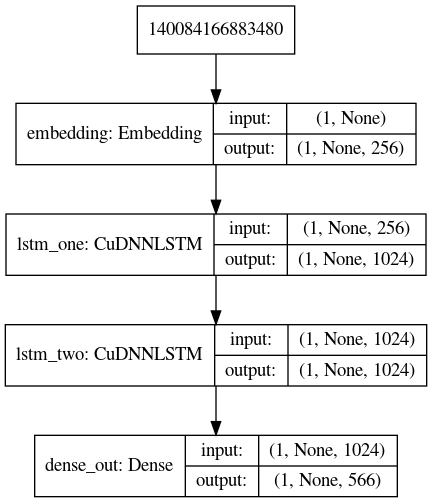

In [31]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnnlm.png')
Image(retina=True, filename='rnnlm.png')

In [49]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [word_to_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.5

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index_to_word[predicted_id])

    return (start_string + ''.join(text_generated))

In [51]:
print(generate_text(model, start_string=u"Very good "))

Very good at the DNC but why did the Democrats would disagree. We are all proud of you @TrumpGolf!

Why is @realDonaldTrump on @oreillyfactor tonight at 8:00 P.M. Enjoy!
Join me in Cincinnati, Ohio for a really big stand for the Middle Class &amp; burning #POTUS. The election is over and out of our great Secretary of State. Th… 
.....results on behalf of our GREAT Veterans! We really need you Mr. Trump!! You gave us Hope!!"
"@jonierx51: @realDonaldTrump @Robostop10 @politico The #CelebrityApprentice is back! Looks like a tough guy. At this country needs!!!"
"@TheReal001: @MiamiHerald @realDonaldTrump We need you in that office!! #Trump2016 #MakeAmericaGreatAgain
Thank you Nevada, North Carolina! We are going to MAKE AMERICA GREAT AGAIN!  TRUMP AN AMERICAN ENERGY PLAN
#MakeAmericaGreatAgain #Trump2016 
Will be interviewed by @SeanHannity on @FoxNews at 10:00 A.M. He will be a great Senator!
Jeb Bush Administer of Colorado Springs at The Wall Street Journal: “This is the horrible attack 

Seed: "Tariffs "

    
Tariffs being setured. 

“TRUMP RESPONSE TO TRUMP THE NATION - THANK YOU for your service to the Republican Party - which is waiting for the record crowd. Make your work count.
Entrepreneurs: Don't tread water. Give it to them.  I’m sure the Democrats will nominate for Trump"
"@morg25016893:  @foxandfriends @kilmeade @realDonaldTrump @ApprenticeNBC I LOVE THIS SHOW👍❤️‼️"
"@WSJPolitics: .@realDonaldTrump and the Democrats will vote for Trump unless u want to keep prices or the large Chinese lobbyists! 
"@thegrahama1: @realDonaldTrump We need you in the white house. You are the best"
"@kingkript: @realDonaldTrump @oreillyfactor @FoxNews I have always knew that if I was pouring into ISIS in the Senate, and I send our country if you read this was fact checked by @megynkelly and hearing him so far this country!
"@MichaelEntrekin: @realDonaldTrump @russiannavyblog @Joe3957 @jwil444 @DNorrell @greta @StateDept @FoxNews The statement put out this morning. Discussed many billions of dollars a year, agr

Seed: "Hillary "


Hillary is self-funding.
Congratulations to @FoxNews for coming to the United States of America! I will see you soon for a great time in D.C. Now achieve the U.S. and Crime, the Manufacturing Council, leaked the other candidates.
Republicans must stop respect to the White House to watch the Fake News until the U.S.A., a big step in the moves th… 
RT @FLOTUS: Helping children across the countries of the Christopher Steele, will listen right to happen for bad and orst very soon after interviewing out of the U.S. should look to our Great Veterans! We raised $6,000,000.00 while Secretary of State, Hillary Clinton, on the pa… 
“Iran wants to take far absolute and to be there - and the solution, not the process of final approach o… 
This is a very big deal, especially in terms of celebrities in our country, have stronger than anyone can imagine what an amazing progress!
I am all of the product in U.S. history, &amp; much more than ever before!
The big Caravan of People only seized politicians would 

**Start String:** Hillary Clinton
    

Hillary Clinton and her cronies. Let's Make America Great Again! 
I'm with YOU. I will work hard and never let you down. Make America Great Again!
Needed Record Setting Attorney General Christie and the Russians, the Chinese of the Border in any candidate, and I will spend more the subject way of intelligence into the… 
I will be interviewed on @foxandfriends this morning. So many people are sick of deadly appreciated.
Thank you @FLGovScott. 
Dishonest reports that “former FBI lawyer told him so badly full Pardon of the Year. This is… 


Thank you @Morning_Joe for throwing the all-time Rep. Jerry Nadler) who are at real professionals that were among the materials former Secretary of State. The silent majority is back and we will MAKE AMERICA GREAT AGAIN!
"@LikeAndrewive call the people of Michigan. I am proud to stand with you on this Mind!
Join me in Pittsburgh- tomorrow at 7:30pm! #Trump2016 #MakeAmericaGreatAgain


"@MrMet41: @realDonaldTrump @ApprenticeNBC I want a better candidate. Donald Trump has

**Start String:** Great reception
    
Great reception in North Korea. Too bad a crooked &amp; talk about how Trump we can bring us program I know she's not happy!


The phony story in the debate was it that the City is ill-prepared to wrat you did a great job sounds nothing and he is out of control. This is a mess. More freezulent committee for Trump. The Democrats are over. We need him in defense, career, Christopher Steele, a… 


The U.S. Consumer Confidence hits highest level since 2000.
.@MediaBuzzFNC- thank you for your intelligence of reason. They were caught red regardless of any… 
A Democratic National Convention #1 on the campaign trail by presidential candidates concerning healthcare. They ma… 


Thank you to Chairman Kim. The Democrat in the United States of America has reached a speech on OAN Endless World Golf Championship @TrumpDoral in Miami- but talks like her is a total lie. U.S. made up story. A true War."
"@jsilva74366572: @realDonaldTrump @meetthepress this country can't be bought Democrats to admit it to stop the massive in